<a href="https://colab.research.google.com/github/alvitay/Malaria-Detection/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

## <b>Objective</b>

We are trying to analyze histopathology images of uninfected and infected images and create a workflow that automatically identifies infected images as accurately and reliably as possible. For this, we are using supervised learning with labeled data set and convolutional neural network architecture. The problem eventually is of Binary Classification type.


## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [104]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <b>Loading libraries</b>

In [105]:
# Importing libraries required to load the data
import zipfile
import os
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import cv2
import tensorflow as tf

# Keras Sequential Model
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Importing all the different layers and optimizers. Getting a few extra libraries that may or may not be needed.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
# Optimizers
from tensorflow.keras.optimizers import Adam,SGD

# For Categorical variables
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)

pd.set_option("display.max_rows", 200)

### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [106]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Malaria Prediction/cell_images.zip'


# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:

    zip_ref.extractall()

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [107]:
# Storing the path of the extracted "train" folder
train_dir = '/content/cell_images/train'

# Size of image so that each image has the same size
SIZE = 64

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [108]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:

    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)


    for i, image_name in enumerate(images_path):

        try:

            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':

                train_labels.append(1)

            else:

                train_labels.append(0)

        except Exception:

            pass

# Converting lists to arrays
train_images = np.array(train_images)

train_labels = np.array(train_labels)

In [109]:
# Storing the path of the extracted "test" folder
test_dir = '/content/cell_images/test'

# Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [110]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:

    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):

        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':

                test_labels.append(1)

            else:

                test_labels.append(0)

        except Exception:

            pass

# Converting lists to arrays
test_images = np.array(test_images)

test_labels = np.array(test_labels)

###<b> Check the shape of train and test images

In [111]:
np.shape(train_images), np.shape(test_images)

((24958, 64, 64, 3), (2600, 64, 64, 3))

###<b> Check the shape of train and test labels

In [112]:
np.shape(train_labels), np.shape(test_labels)

((24958,), (2600,))

####<b> Observations and insights: There are 24958 training images, each is 64x64x3 and 2600 test images of the same size. All of the data is labeled as well.


### <b>Check the minimum and maximum range of pixel values for train and test images

In [113]:
np.max(train_images), np.min(train_images), np.max(test_images), np.min(test_images)


(255, 0, 255, 0)

####<b> Observations and insights: The maximum and minimum intensity values in any channel for all images is 255 and 0, respectively.



###<b> Count the number of values in both uninfected and parasitized

In [114]:
len(np.unique(train_images)), len(np.unique(test_images))


(256, 256)

###<b>Normalize the images

In [115]:
# Try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images= train_images.astype('float32')/255.0

test_images= test_images.astype('float32')/255.0

train_images_n=cv2.normalize(train_images,None, 0,1,cv2.NORM_MINMAX)
test_images_n=cv2.normalize(test_images,None, 0,1,cv2.NORM_MINMAX)

In [116]:
np.max(train_images), np.min(train_images), np.max(test_images), np.min(test_images)

(1.0, 0.0, 1.0, 0.0)

**Observations and Insights: As expected, the maximum and minimum values of Training and Test data is 1.0 and 0.0, respectively.**

# **Plot to check if the data is balanced (Pandas Dataframe way)**

In [117]:
#Trying a Pandas DataFrame approach for barplot

train_uninfected_num=len(os.listdir(train_dir + '/uninfected'))
train_paratisized_num=len(os.listdir(train_dir + '/parasitized'))
test_uninfected_num=len(os.listdir(test_dir + '/uninfected'))
test_paratisized_num=len(os.listdir(test_dir + '/parasitized'))
print("Number of images in each class:   ", train_uninfected_num, train_paratisized_num, test_uninfected_num, test_paratisized_num)

Number of images in each class:    12376 12582 1300 1300


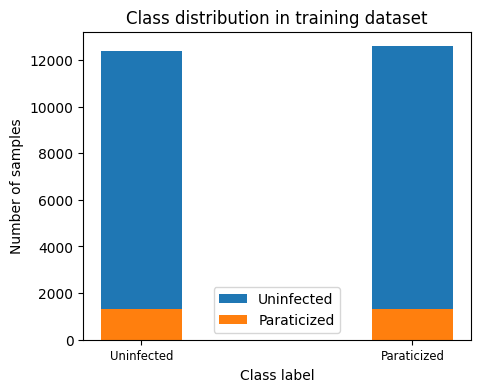

In [118]:
plt.figure(figsize = (5, 4))

train_data = {'Uninfected': train_uninfected_num, 'Paraticized': train_paratisized_num}
df_train = pd.Series(train_data)
test_data = {'Uninfected': test_uninfected_num, 'Paraticized': test_paratisized_num}
df_test = pd.Series(test_data)

plt.bar(range(len(df_train)), df_train.values, width=0.3, align = 'center')

plt.bar(range(len(df_test)), df_test.values, width=0.3, align = 'center')

plt.title('Class distribution in training dataset')
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.xticks(range(len(df_train)), df_train.index.values, size = 'small')
plt.legend(train_data)
plt.show()

###<b> Plot to check if the data is balanced (Matplotlib way)

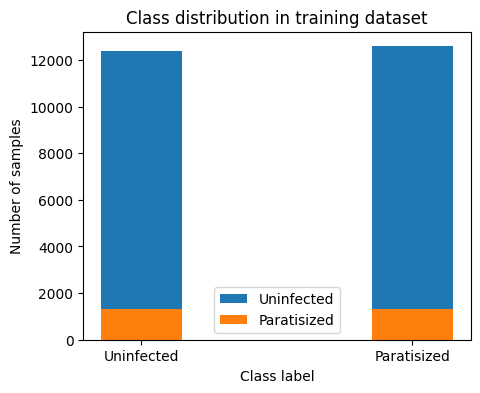

In [119]:
plt.figure(figsize = (5, 4))

# Here it is done via finding Unique Labels.
unique_labels_train, counts_train = np.unique(train_labels, return_counts=True)
unique_labels_test, counts_test = np.unique(test_labels, return_counts=True)
#print('unique labels',unique_labels)
xlabels=['Uninfected','Paratisized']
plt.bar(xlabels, counts_train,width=0.3, align='center')
plt.bar(xlabels, counts_test,width=0.3, align='center')
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in training dataset')
plt.legend(xlabels)
plt.show()


####<b> Observations and insights: The barplots in both ways show that for both categories the counts are roughly equal. Therefore, the data is balanced.

### <b>Data Exploration</b>
Let's visualize the images from the train data

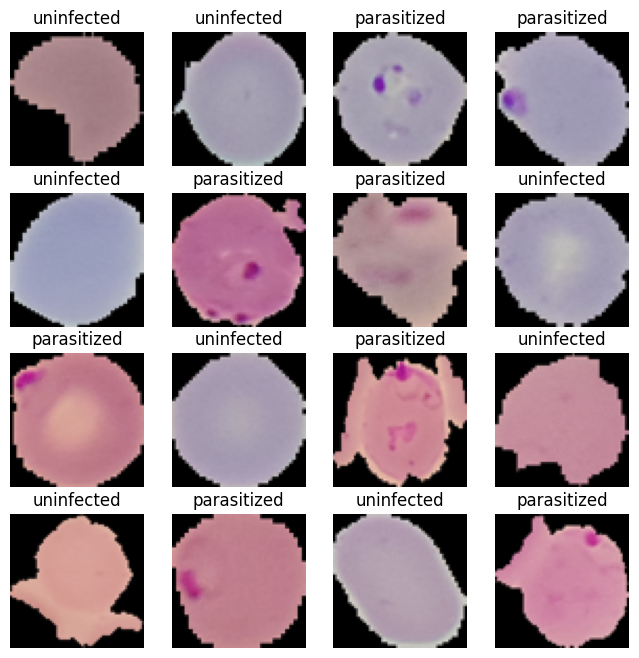

In [120]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)

plt.figure(1, figsize = (8 , 8))

for n in range(1, 17):

    plt.subplot(4, 4, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

####<b> Observations and insights: Uninfected images have a uniform intensity in the interior of the cell, whereas infected cells have one or more colored blobs inside the cell body. This is a distinguishing feature that must be picked up by the CNN models accurately. These parasitic blobs are irregular in shape and size and are located at different locations.

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

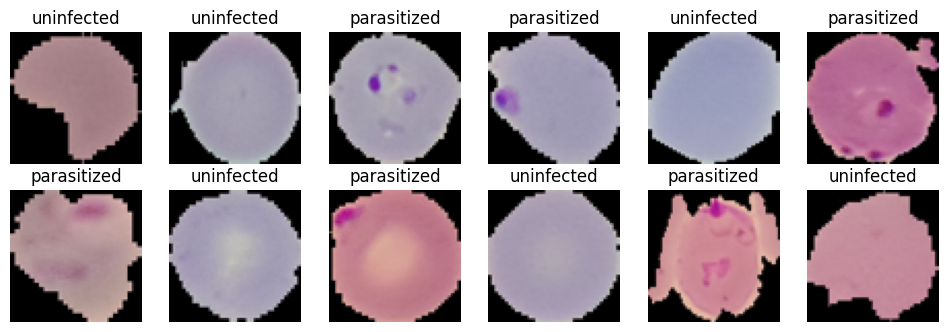

In [121]:
np.random.seed(42)

plt.figure(1, figsize = (12 , 12))

for n in range(1, 13):

    plt.subplot(6, 6, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')



####<b>Observations and insights: Same as above. We see more variety of cell shapes and intances of infection.

###<b> Plotting the mean images for parasitized and uninfected

In [122]:
#First, define a function to calculate the mean of images.
# "img_mat" is the matrix of the image, "case" is uninfected or paratisized
def mean_img(img_mat, case):

    # Calculate the average
    mean_img = np.mean(img_mat, axis = 0)[0]

    # Reshape it back to a matrix
    plt.imshow(mean_img)

    plt.title(f'Average {case}')

    plt.axis('off')

    plt.show()

    return mean_img

<b> Mean image for parasitized

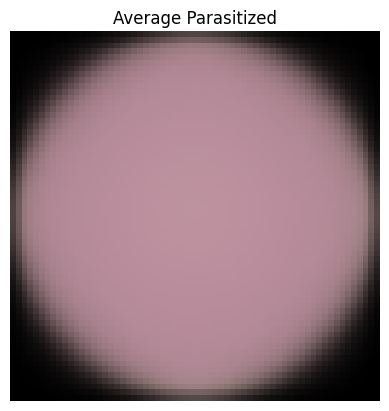

In [123]:
# If the label = 1 then the image is parasitised and if the label = 0 then the image is uninfected
parasitized_data = []  # Create a list to store the parasitized data

for img, label in zip(train_images, train_labels):

        if label == 1:

              parasitized_data.append([img])

parasitized_mean = mean_img(np.array(parasitized_data), 'Parasitized')   # find the mean

<b> Mean image for uninfected

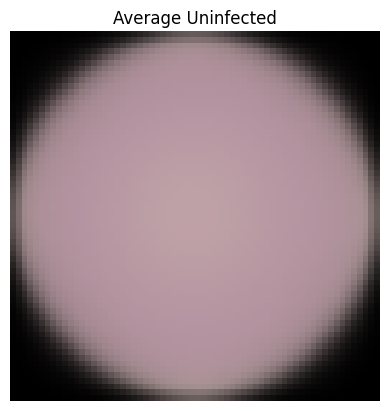

In [124]:
# If the label = 1 then the image is parasitised and if the label = 0 then the image is uninfected
uninfected_data = []  # Create a list to store the parasitized data

for img, label in zip(train_images, train_labels):

        if label == 0:

              uninfected_data.append([img])

uninfected_mean = mean_img(np.array(uninfected_data), 'Uninfected')   # find the mean




####<b> Observations and insights: They look the same. This is because for parasticized images, the colored blob indicating infection is always at different locations. For each such colored blob, there are many more images where there is no colored blob in that location. Thus, on average, it will show up as a diminished but uniform intenisty patch.

### <b>Converting RGB to HSV of Images using OpenCV


###<b> Converting the train data

In [125]:
# The best way to do that is to use OpenCV
#import cv2

hsvarray_train=[]   # to hold the HSV image array

for i in np.arange(0, 100, 1):

  hvtr = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2HSV)

  hsvarray_train.append(hvtr)

hsvarray_train = np.array(hsvarray_train)

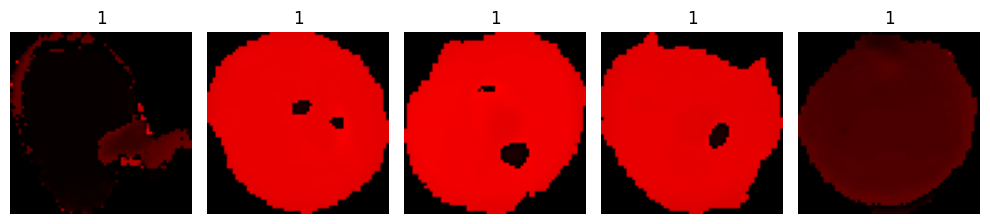

In [126]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (10, 10))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(hsvarray_train[i].astype(np.uint8))

  ax[t].set_axis_off()

  fig.tight_layout()

###<b> Converting the test data

In [127]:
hsvarray_test=[]   # to hold the HSV image array

for i in np.arange(0, 100, 1):

  hvtst = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2HSV)

  hsvarray_test.append(hvtst)

hsvarray_test = np.array(hsvarray_test)

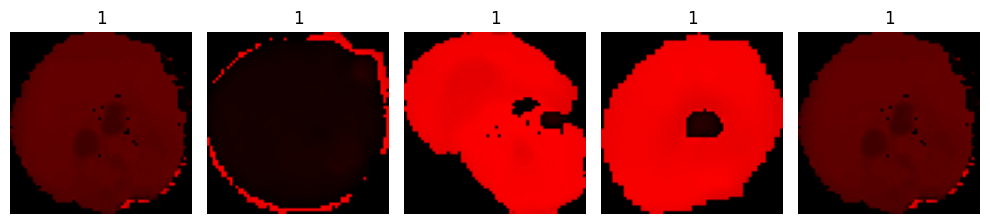

In [128]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (10, 10))

for t, i in zip(range(5), viewimage):

  Title = test_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(hsvarray_test[i].astype(np.uint8))

  ax[t].set_axis_off()

  fig.tight_layout()

####<b>Observations and insights: All infected cells have blobs inside the cell body.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [129]:
gbtrain = []  # To hold the blurred images

for i in np.arange(0, 100, 1):

  b = cv2.GaussianBlur(train_images[i], (5, 5), 0)

  gbtrain.append(b)

gbtrain = np.array(gbtrain)

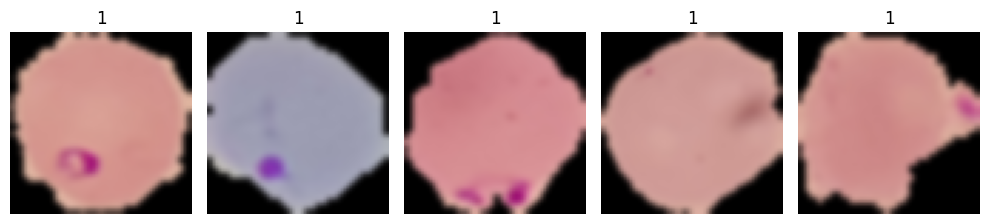

In [130]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (10, 10))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)


  ax[t].imshow(gbtrain[i])

  ax[t].set_axis_off()

  fig.tight_layout()

###<b> Gaussian Blurring on test data

In [131]:
gbtest = []  # To hold the blurred images

for i in np.arange(0, 100, 1):

  b = cv2.GaussianBlur(test_images[i], (5, 5), 0)

  gbtest.append(b)

gbtest = np.array(gbtest)

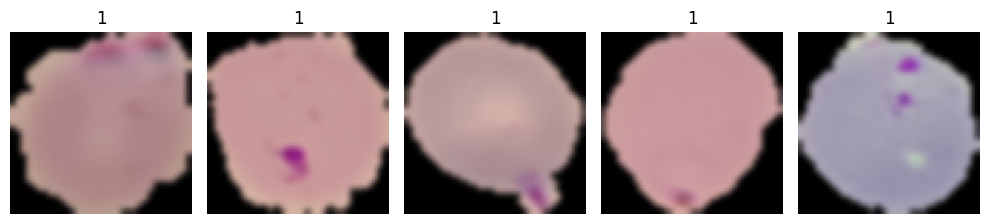

In [132]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (10, 10))

for t, i in zip(range(5), viewimage):

  Title = test_labels[i]

  ax[t].set_title(Title)


  ax[t].imshow(gbtest[i])

  ax[t].set_axis_off()

  fig.tight_layout()

####**Observations and insights: The mostt important observation here is the smoothing of features and removal of noise.**

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

**Blurring helps with removing noise and hence can benefit overfitting issue later on. The models should not be fitting the noise as well as the features, so the less high frequency noise we have the better. On the other hand, it dilutes the distinguishing feature of paraticized cells, viz. the colored blobs inside the cell body.**

Other additional operations that will yield very nice identifiable bright spots that are signatures of pathogen in a color-inverted image:

- Contrast Enhance (possibly CLAHE)
- Histogram Equalization
- We could use "open" and "close" morphological operations that do erosion and dilation in sequence to enhance the small blobs in paracitized cells.


**I will come back to these experiemnts once I am done with all the other questions.**

**One Hot Encoding the train and test labels**

In [133]:
# Encoding Train Labels
train_labels = to_categorical(train_labels, 2)

# Encode test labels
test_labels = to_categorical(test_labels, 2)

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [134]:
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

In [135]:
backend.clear_session()


In [136]:
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

###<b> Building the model
Convolutional Model with the following architecture:<br>
Three 32 filter layers, kernel size 2, ReLU activation, Max Pooling, and Dropout layers after each convolutional layer. The final layer is a fully connected dense 512 units layer with ReLU activation and a higher dropout that is fed to the dense classifier layer with 2 outputs and a softmax activation function.


In [137]:
from keras.layers import Dense, LeakyReLU

In [138]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation = "relu"))

model.add(Dropout(0.4))

model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,058,786 (4.04 MB)

 Trainable params: 1,058,786 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

**Compiling the Model**

In [139]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks

In [140]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint('.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train our Model

In [141]:
# Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ]
history = model.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 30, verbose = 1)

Epoch 1/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7037 - loss: 0.5506 - val_accuracy: 0.9225 - val_loss: 0.3252
Epoch 2/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9403 - loss: 0.1356 - val_accuracy: 0.9551 - val_loss: 0.1390
Epoch 3/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9647 - loss: 0.1055 - val_accuracy: 0.9832 - val_loss: 0.0820
Epoch 4/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9760 - loss: 0.0750 - val_accuracy: 0.9796 - val_loss: 0.0879
Epoch 5/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9771 - loss: 0.0689 - val_accuracy: 0.9842 - val_loss: 0.0646
Epoch 6/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9777 - loss: 0.0660 - val_accuracy: 0.9848 - val_loss: 0.0601
Epoch 7/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9792 - loss: 0.0615 - val_accuracy: 0.9804 - val_loss: 0.0656
Epoch 8/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9797 - loss: 0.0581 - val_accuracy: 

###<b> Evaluating the model on test data

In [142]:
accuracy = model.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9854 - loss: 0.0379

 Test_Accuracy:- 0.9842307567596436


<b> Plotting the confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



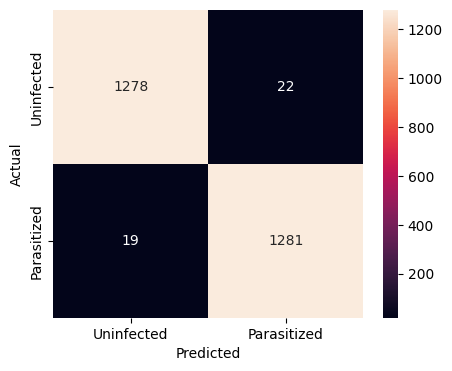

In [143]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (5, 4))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b>Plotting the train and validation curves

In [144]:
# Function to plot train and validation accuracy
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (5, 5))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="lower right")

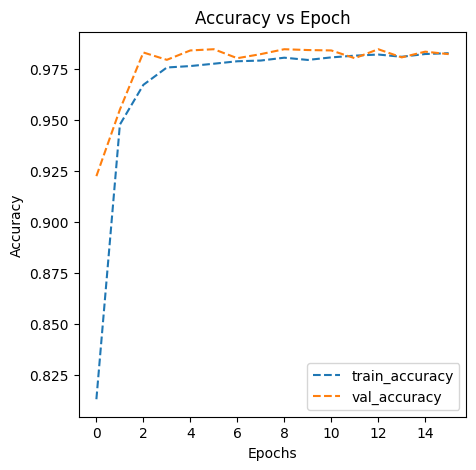

In [145]:
plot_accuracy(history)

**Observations: Validation accuracy slightly higher than training accuracy.<br> Precision and Recall numbers are reasonably good. The validation accuracy is dropping so it could have been stopped a bit earlier.**

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers. Five layers instead of three.


In [146]:
backend.clear_session()

In [147]:
model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(512, activation = "relu"))

model1.add(Dropout(0.4))

model1.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 32)            │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,002 (328.13 KB)

 Trainable params: 84,002 (328.13 KB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [148]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks: Trying longer patience=5

In [149]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint('.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [150]:
history1 = model1.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7769 - loss: 0.4322 - val_accuracy: 0.9810 - val_loss: 0.0884
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9722 - loss: 0.0870 - val_accuracy: 0.9830 - val_loss: 0.0571
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9745 - loss: 0.0765 - val_accuracy: 0.9762 - val_loss: 0.0671
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9770 - loss: 0.0693 - val_accuracy: 0.9802 - val_loss: 0.0558
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9741 - loss: 0.0715 - val_accuracy: 0.9804 - val_loss: 0.0571
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9765 - loss: 0.0705 - val_accuracy: 0.9760 - val_loss: 0.0589
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9782 - loss: 0.0638 - val_accuracy: 0.9782 - val_loss: 0.0568
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9783 - loss: 0.0640 - val_accuracy: 

###<b> Evaluating the model

In [151]:
accuracy = model1.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9859 - loss: 0.0438

 Test_Accuracy:- 0.9842307567596436


<b> Plotting the confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



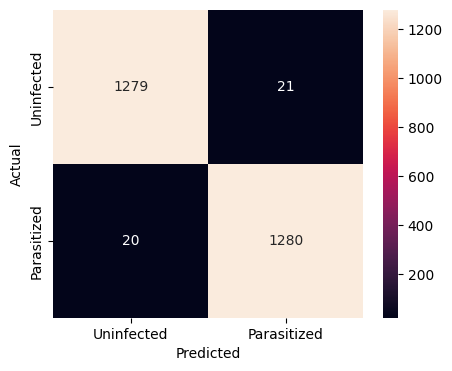

In [152]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model1.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (5, 4))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b> Plotting the train and the validation curves

In [153]:
# Function to plot train and validation accuracy
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (5, 5))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="lower right")

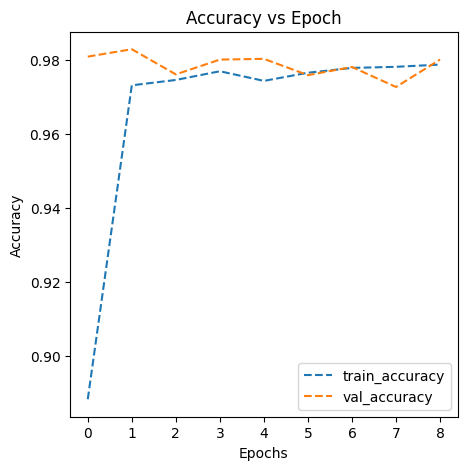

In [154]:
plot_accuracy(history1)

**Observations: This model is better than previous model with both accuracies better aligned.**

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [155]:
backend.clear_session() # Clearing the backend for new model

###<b> Building the Model.

In [156]:
model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = 3, padding = "same", input_shape = (64, 64, 3)))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(BatchNormalization())

#model2.add(Dropout(0.2))

model2.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",input_shape = (64, 64, 3)))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(BatchNormalization())

#model2.add(Dropout(0.2))

model2.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",input_shape = (64, 64, 3)))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(BatchNormalization())

#model2.add(Dropout(0.2))

model2.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",input_shape = (64, 64, 3)))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(BatchNormalization())

#model2.add(Dropout(0.2))

model2.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",input_shape = (64, 64, 3)))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(BatchNormalization())

#model2.add(Dropout(0.2))

model2.add(Flatten())

model2.add(Dense(512))
model2.add(LeakyReLU(alpha=0.1))

model2.add(Dropout(0.4))

model2.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

opt = Adam(learning_rate=0.001)

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 105,602 (412.51 KB)

 Trainable params: 105,282 (411.26 KB)

 Non-trainable params: 320 (1.25 KB)

###<b>Compiling the model

In [157]:
model2.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

<b> Using callbacks

In [158]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint('.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

<b>Fit and train the model: <br>
After running the previous models with a few variations, I found that callbacks is not necessarily the best option and it is good to see what happens to the training and validation accuracy for more epochs, so I will not be using callbacks from now on.

In [159]:
history2 = model2.fit(train_images, train_labels, batch_size = 32, validation_split = 0.2, epochs = 30, verbose = 1)

Epoch 1/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8527 - loss: 0.3131 - val_accuracy: 0.9980 - val_loss: 0.0104
Epoch 2/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9747 - loss: 0.0749 - val_accuracy: 0.9854 - val_loss: 0.0544
Epoch 3/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9783 - loss: 0.0624 - val_accuracy: 0.9808 - val_loss: 0.0772
Epoch 4/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9802 - loss: 0.0563 - val_accuracy: 0.9792 - val_loss: 0.0821
Epoch 5/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9828 - loss: 0.0510 - val_accuracy: 0.9722 - val_loss: 0.0940
Epoch 6/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9832 - loss: 0.0466 - val_accuracy: 0.9948 - val_loss: 0.0176
Epoch 7/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9837 - loss: 0.0466 - val_accuracy: 0.9906 - val_loss: 0.0394
Epoch 8/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9864 - loss: 0.0390 - val_accuracy: 

<b>Plotting the train and validation accuracy

In [160]:
# Function to plot train and validation accuracy
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (5, 5))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="lower right")


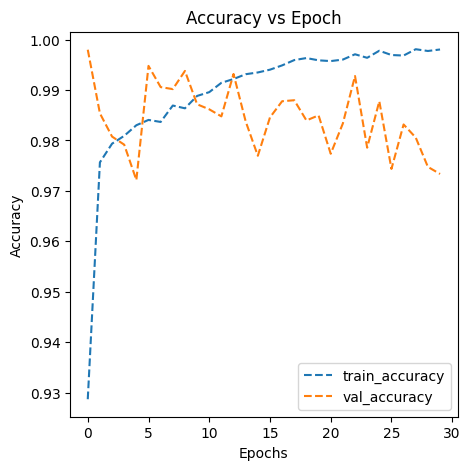

In [161]:
plot_accuracy(history2)

**Observations and Insights:**

**I have deliberately not used "Callbacks" to see how the model performs over many epochs. If there are Dropout layers in a model, they usually take many epochs to stabilize and affect the network so callbacks maynot be a good idea.**

**Here, Training Accuracy is close to 1, whereas Validation accuracy is around .98, which is a very nice result. Batch Normalization has indeed helped. Secondly, unlike previous models, Validation accuracy is lower than training accuracy, as it normally should be.**

**I have also read that BN and Dropout used together tend to make the model worse if used in the wrong order (Reference to be cited later). Here, I have used Dropout after all the BN steps, just before the softmax layer. It has resulted in marked improvement from all my previous attempts (not shown here) for this model using both Dropout and BN together in every layer.**

###<b>Evaluating the model

In [162]:
accuracy = model2.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9850 - loss: 0.0765

 Test_Accuracy:- 0.9803845882415771


<b> Generate the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



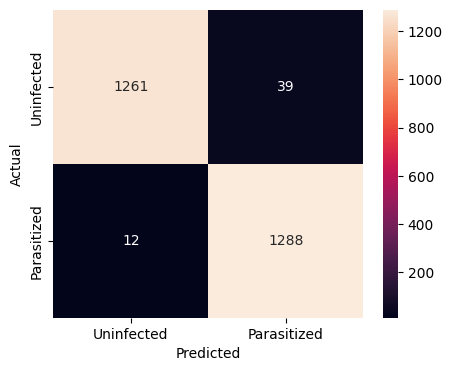

In [163]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model2.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (5, 4))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

####<b>Observations and insights: This is so far the best model. All of the changes mentioned earlier have helped to reduce False Negatives. This is important because it is critical that an infected person is not diagnosed as uninfected.

###<b>Model 3 with Data Augmentation

In [164]:
backend.clear_session()

###<b> Use image data generator

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
# I have tried many augmentation steps, pretty much every option that was available, but most don't seem to make any difference.
# Here, I am showing a run with a few basic transformations.
train_datagen = ImageDataGenerator(
                                   horizontal_flip = True,
                                   #vertical_flip = True,
                                   #shear_range=0.2,
                                   zoom_range = 0.5,
                                   rotation_range = 30)

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



**I checked with every option in ImageDataGenerator like shearing, shifts, flips, etc. I did not see a significant improvement. In fact, most of the time the results were worse.**

####<B>Visualizing Augmented images

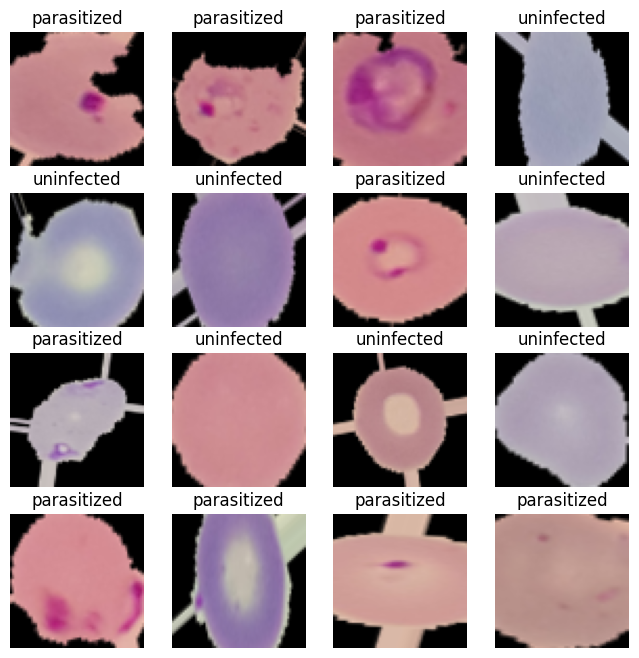

In [166]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (8, 8))

fig.set_size_inches(8, 8)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1:

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

####<b>Observations and insights: I am not sure why those long bands connecting the edge of the cell to image boundary is forming. It is somewhat undesirable. I have to investigate various data augmentation possibilities in more detail.

###<b>Building the Model

In [167]:
model3 = Sequential()

model3.add(Conv2D(filters = 32, kernel_size = 3, padding = "same", input_shape = (64, 64, 3)))
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(BatchNormalization())

#model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",input_shape = (64, 64, 3)))
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(BatchNormalization())

#model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",input_shape = (64, 64, 3)))
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(BatchNormalization())

#model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",input_shape = (64, 64, 3)))
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(BatchNormalization())

#model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 3, padding = "same",input_shape = (64, 64, 3)))
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(BatchNormalization())

#model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(512))
model3.add(LeakyReLU(alpha=0.1))

model3.add(Dropout(0.4))

model3.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

opt = Adam(learning_rate=0.001)

model3.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 105,602 (412.51 KB)

 Trainable params: 105,282 (411.26 KB)

 Non-trainable params: 320 (1.25 KB)

<b>Using Callbacks

In [168]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint('.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [169]:
history3 = model3.fit(train_generator,
                                  validation_data = val_generator,
                                  batch_size = 32,
                                  epochs = 30, verbose = 1)

Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 34s 87ms/step - accuracy: 0.7892 - loss: 0.4319 - val_accuracy: 0.7837 - val_loss: 0.4523
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.9455 - loss: 0.1588 - val_accuracy: 0.9736 - val_loss: 0.0915
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.9527 - loss: 0.1421 - val_accuracy: 0.9788 - val_loss: 0.0682
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.9529 - loss: 0.1404 - val_accuracy: 0.9784 - val_loss: 0.0667
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.9568 - loss: 0.1321 - val_accuracy: 0.9804 - val_loss: 0.0646
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.9553 - loss: 0.1299 - val_accuracy: 0.9800 - val_loss: 0.0770
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.9592 - loss: 0.1221 - val_accuracy: 0.9804 - val_loss: 0.0670
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.9576 - loss: 0.1256 - 

###<B>Evaluating the model

<b>Plot the train and validation accuracy

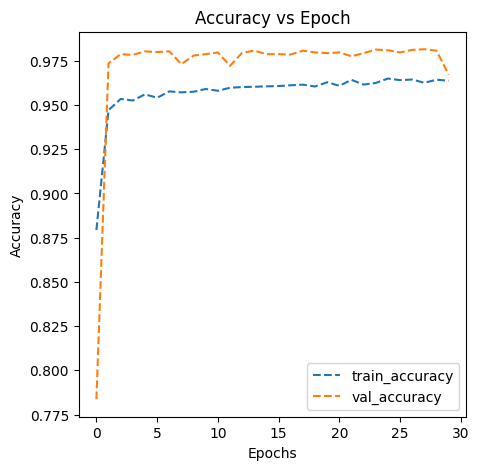

In [170]:
plot_accuracy(history3)

In [171]:
accuracy3 = model3.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9644 - loss: 0.0911

 Test_Accuracy:- 0.9803845882415771


<B>Plotting the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1300
           1       0.99      0.96      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



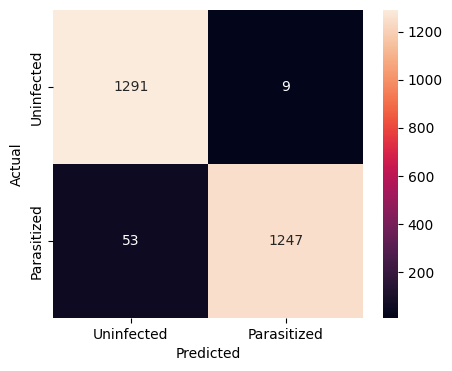

In [172]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model3.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (5, 4))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Importing VGG16 network upto block 5, keeping it non-trainable.
- Adding Fully Connected Layers on top of it

In [173]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [174]:
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (64, 64, 3))

vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [175]:
transfer_layer = vgg.get_layer('block5_pool')

vgg.trainable = False

# Flatten the output from the 3rd block of the VGG16 model
# Add classification layers on top of it
x = Flatten()(transfer_layer.output)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
#x = Dropout(0.3)(x)

# Similarly add a dense layer with 128 neurons
x = Dense(128, activation = 'relu')(x)
x = BatchNormalization()(x)
#Dropout layer
#x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)
# Again, keeping dropout after all the BN layers
x = Dropout(0.3)(x)
pred = Dense(2, activation = 'softmax')(x)

model4 = Model(vgg.input, pred) # Initializing the model

model4.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,282,306 (58.30 MB)

 Trainable params: 566,722 (2.16 MB)

 Non-trainable params: 14,715,584 (56.14 MB)

###<b>Compiling the model

In [176]:
opt = Adam(learning_rate=0.001)

model4.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])


<b> using callbacks

In [177]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint('.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [178]:
history4 = model4.fit(train_generator,
                                  validation_data=val_generator,
                                  validation_split=0.2,
                                  batch_size = 32,
                                  epochs = 30, verbose = 1)

Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.8136 - loss: 0.4280 - val_accuracy: 0.9187 - val_loss: 0.2153
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.8729 - loss: 0.3069 - val_accuracy: 0.9209 - val_loss: 0.2019
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.8812 - loss: 0.2824 - val_accuracy: 0.9331 - val_loss: 0.1772
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8878 - loss: 0.2799 - val_accuracy: 0.7983 - val_loss: 0.3998
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8925 - loss: 0.2651 - val_accuracy: 0.9291 - val_loss: 0.1839
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.8937 - loss: 0.2619 - val_accuracy: 0.9335 - val_loss: 0.1695
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8915 - loss: 0.2577 - val_accuracy: 0.9405 - val_loss: 0.1643
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8945 - loss: 0.2590 - 

In [179]:
# Function to plot train and validation accuracy
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (5, 5))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="lower right")


<b>Plot the train and validation accuracy

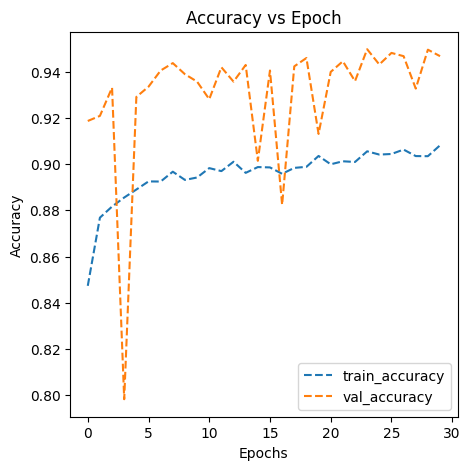

In [180]:
plot_accuracy(history4)

###**Observations and insights: _____**

*   What can be observed from the validation and train curves?

**We are back to validation accuracy being higher than training accuracy. This could be due to not having enough data augmentation. It is possible that if more variations in the data are incorporated, both accuracies maybe closer. It could also be that more fine tuning is required in the final layers. I also read that VGG16 is trained on images normalized by subtracting the mean. Our images are normalized differently and maybe they need to be normalized the same way.**

###<b> Evaluating the model

In [181]:
accuracy4 = model4.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy4[1])


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9660 - loss: 0.0965

 Test_Accuracy:- 0.9388461709022522


<b>Plotting the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      1300
           1       0.91      0.97      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



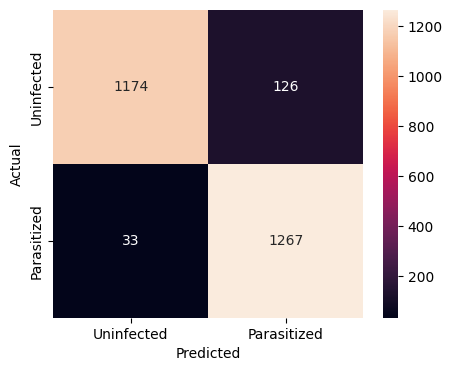

In [182]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model4.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (5, 4))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report? <br>
**This is the worst performing model of the lot. That could be because I haven't fully mastered the art of transfer learning and fine tuning transfer learning models.*
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.

**Based on both the accuracy numbers and the Confusion Matrix, the second model with five layers and batch normalization was the best. The third model with data augmentation is also close second. The accuracy numbers are very good but confusion matrix shows a bit higher instances of parasitized cases classified as uninfected.**


####<b> Observations and Conclusions drawn from the final model: The second model not only had excellent training and validation accuracy, it also had equally good Test Accuracy. Moreover, from Confusion Matrix, it had the least number of False negatives, meaning, it had the lowest number of cases where a parasitized cell was identified as uninfected. This is highly desireable to prevent fatalities and spread of infection.



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?

**We can try ResNet50 architecture as a pre-trained model. We can also employ image pre-processing steps like contrast enhancement, histogram equalization, single channel processing etc.**

*  You can try to build a model using these HSV images and compare them with your other models.

**I plan to exeriment with not just HSV but also the LAB colormap images. They are particularly suitable for CLAHE and other contrast enhancing techniques.**

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

**The most meaningful insight here is that the distinguishing feature of parasitized cells is a small blobs that are darker than the background but otherwise the image has uniform intensity. This mean that the CNN architecture doesn't need to be overly complicated and any reasonably deep network with appropriate batch normalization or dropout or regularization method will work.**

**It is indeed possible to automate the pocess of identifying infected cells in a relatively short time. It doesn't take too long to run on my machine.**

